In [1]:
using PyCall, PyPlot
using JLD2, FileIO, NetCDF
using Elefridge, StatsBase, Statistics
using ZfpCompression, TranscodingStreams, CodecZstd

ticker = pyimport("matplotlib.ticker");

ZstdCompressorL3 = ZstdCompressor(level=3)
TranscodingStreams.initialize(ZstdCompressorL3)

ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [2]:
path = "/network/aopp/chaos/pred/kloewer/esowc/"
member1files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"member1")))
steps = [parse(Int,split(split(file,"step")[2],".")[1]) for file in member1files]
sort!(steps)

ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step0.ll.nc"))
temp = ncfile.vars["t"][:,:,:];

In [3]:
Nens = 25
Nbytes = 4   # 4 bytes for float32
Nsteps = length(steps)
Nlon,Nlat,Nvert = size(temp)

(1800, 901, 91)

## 1. ZFP: Compress only horizontal 2D

In [4]:
cfs_zfp_2d_hori_all = fill(0.0,Nvert)
ori_size = Nlon*Nlat*Nbytes*2   # relative to Float64

for iv in 1:Nvert
    print("$iv,")
    s = steps[rand(1:Nsteps)]    # pick a random time step
    m = rand(1:Nens)             # pick a random ensemble member
    
    # load file
    ncfile = NetCDF.open(joinpath(path,"member$m","ensemble.t.member$m.step$s.ll.nc"))
    temp = ncfile.vars["t"][:,:,iv];
    
    # compress only vertical level
    cfs_zfp_2d_hori_all[iv] = ori_size/sizeof(zfp_compress(temp,precision=13))
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,

## 2. ZFP: Compress spatial 3D

In [5]:
cfs_zfp_3d_space_all = fill(0.0,Nens)
ori_size = Nlon*Nlat*Nvert*Nbytes*2   # relative to Float64

for ie in 1:Nens
    print("$ie,")
    s = steps[rand(1:Nsteps)] # pick a random time step
    
    # load member ie
    ncfile = NetCDF.open(joinpath(path,"member$ie","ensemble.t.member$ie.step$s.ll.nc"))
    temp = ncfile.vars["t"][:,:,:];
    
    # compress the 3d field
    cfs_zfp_3d_space_all[ie] = ori_size/sizeof(zfp_compress(temp,precision=13))
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

## 3. ZFP: Compress horizontal + time 3D

In [6]:
cfs_zfp_3d_horitime_all = fill(0.0,Nvert)
Nsteps1h = 91                             # there are 91 steps with dt=1h
ori_size = Nlon*Nlat*Nbytes*2*Nsteps1h    # relative to Float64

for iv in 1:Nvert
    print("$iv,")
    temp = fill(0.0,Nlon,Nlat,Nsteps1h)
    
    for i in 1:Nsteps1h
        t = steps[i]
        
        # load time steps
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$t.ll.nc"))
        temp[:,:,i] = ncfile.vars["t"][:,:,iv];
    end
    
    cfs_zfp_3d_horitime_all[iv] = ori_size/sizeof(zfp_compress(temp,precision=13))
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,

## 4. ZFP: Compress in space and time

In [7]:
chunksize = 8
Nsteps1h = 91                              # there are 91 steps with dt=1h
Nchunks = Nsteps1h÷chunksize               # compress in chunks of 4 time steps
cfs_zfp_4d_spacetime = fill(0.0,Nchunks)
ori_size = Nlon*Nlat*Nvert*Nbytes*2*chunksize      # relative to Float64

for ic in 1:Nchunks
    print("$ic")
    
    temp = fill(0f0,Nlon,Nlat,Nvert,chunksize)
    for i in 1:chunksize
        s = steps[(ic-1)*chunksize+i]
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$s.ll.nc"))
        temp[:,:,:,i] = ncfile.vars["t"][:,:,:]
    end
    print("L")
    
    if ic <= 4
        precision = 13
    else
        precision = 12
    end
    
    cf = ori_size/sizeof(zfp_compress(temp,precision=precision))
    cfs_zfp_4d_spacetime[ic] = cf
    print("X $(Int(round(cf))),")
end

1LX 96,2LX 102,3LX 106,4LX 110,5LX 178,6LX 180,7LX 182,8LX 183,9LX 183,10LX 183,11LX 184,

In [9]:
1 ./ mean(1 ./ cfs_zfp_4d_spacetime)

142.52773235136786

## 5. ZSTD COMPRESS ALONG VARIOUS DIMENSIONS

In [36]:
# LONGITUDE, LATITUDE, VERTICAL
cfs_zstd_longitude = fill(0.0,Nsteps)
cfs_zstd_latitude = fill(0.0,Nsteps)
cfs_zstd_vertical = fill(0.0,Nsteps)

for i in 1:Nsteps
    print("$i")
    t = steps[i]
        
    # load time step
    ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$t.ll.nc"))
    temp = ncfile.vars["t"][:,:,:]
    print("L")
    
    # LONGITUDE no permutation of dimensions
    round!(temp,7)
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_longitude[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("x")
    
    # LATITUDE
    temp = permutedims(temp,[2,1,3])   # put latitude first
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_latitude[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("y")
    
    # VERTICAL
    temp = permutedims(temp,[3,1,2])   # put vertical first
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_vertical[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("z,")
end

1Lxyz,2Lxyz,3Lxyz,4Lxyz,5Lxyz,6Lxyz,7Lxyz,8Lxyz,9Lxyz,10Lxyz,11Lxyz,12Lxyz,13Lxyz,14Lxyz,15Lxyz,16Lxyz,17Lxyz,18Lxyz,19Lxyz,20Lxyz,21Lxyz,22Lxyz,23Lxyz,24Lxyz,25Lxyz,26Lxyz,27Lxyz,28Lxyz,29Lxyz,30Lxyz,31Lxyz,32Lxyz,33Lxyz,34Lxyz,35Lxyz,36Lxyz,37Lxyz,38Lxyz,39Lxyz,40Lxyz,41Lxyz,42Lxyz,43Lxyz,44Lxyz,45Lxyz,46Lxyz,47Lxyz,48Lxyz,49Lxyz,50Lxyz,51Lxyz,52Lxyz,53Lxyz,54Lxyz,55Lxyz,56Lxyz,57Lxyz,58Lxyz,59Lxyz,60Lxyz,61Lxyz,62Lxyz,63Lxyz,64Lxyz,65Lxyz,66Lxyz,67Lxyz,68Lxyz,69Lxyz,70Lxyz,71Lxyz,72Lxyz,73Lxyz,74Lxyz,75Lxyz,76Lxyz,77Lxyz,78Lxyz,79Lxyz,80Lxyz,81Lxyz,82Lxyz,83Lxyz,84Lxyz,85Lxyz,86Lxyz,87Lxyz,88Lxyz,89Lxyz,90Lxyz,91Lxyz,92Lxyz,93Lxyz,94Lxyz,95Lxyz,96Lxyz,97Lxyz,98Lxyz,99Lxyz,100Lxyz,101Lxyz,102Lxyz,103Lxyz,104Lxyz,105Lxyz,106Lxyz,107Lxyz,108Lxyz,109Lxyz,110Lxyz,111Lxyz,112Lxyz,113Lxyz,114Lxyz,115Lxyz,116Lxyz,117Lxyz,118Lxyz,119Lxyz,120Lxyz,121Lxyz,122Lxyz,123Lxyz,124Lxyz,125Lxyz,126Lxyz,127Lxyz,128Lxyz,129Lxyz,130Lxyz,131Lxyz,132Lxyz,133Lxyz,134Lxyz,135Lxyz,136Lxyz,137Lxyz,138Lxyz,139L

In [8]:
# save(joinpath(path,"analysis/zstd_lonlatvert_compression.jld2"),
#                                         "cfs_zstd_longitude",cfs_zstd_longitude,
#                                         "cfs_zstd_latitude",cfs_zstd_latitude,
#                                         "cfs_zstd_vertical",cfs_zstd_vertical)
cfs_zstd_longitude,cfs_zstd_latitude,cfs_zstd_vertical = 
load(joinpath(path,"analysis/zstd_lonlatvert_compression.jld2"),
                                        "cfs_zstd_longitude",
                                        "cfs_zstd_latitude",
                                        "cfs_zstd_vertical");

In [11]:
# TIME
cfs_zstd_time = fill(0.0,Nvert)

for iv in 1:Nvert
    print("$iv")
    
    temp = fill(0f0,Nsteps1h,Nlon,Nlat)
    
    for it in 1:Nsteps1h
        t = steps[it]
        
        # load time step
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$t.ll.nc"))
        temp[it,:,:] = ncfile.vars["t"][:,:,iv]
    end
    print("L")
    
    # TIME no permutation of dimensions
    round!(temp,7)
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_time[iv] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("x $(Int(round(cfs_zstd_time[iv]))), ")
end

1Lx 74, 2Lx 78, 3Lx 74, 4Lx 70, 5Lx 73, 6Lx 69, 7Lx 74, 8Lx 76, 9Lx 68, 10Lx 61, 11Lx 55, 12Lx 48, 13Lx 43, 14Lx 44, 15Lx 46, 16Lx 49, 17Lx 52, 18Lx 56, 19Lx 59, 20Lx 61, 21Lx 63, 22Lx 65, 23Lx 67, 24Lx 69, 25Lx 70, 26Lx 71, 27Lx 71, 28Lx 71, 29Lx 70, 30Lx 69, 31Lx 68, 32Lx 66, 33Lx 64, 34Lx 63, 35Lx 62, 36Lx 62, 37Lx 62, 38Lx 64, 39Lx 65, 40Lx 67, 41Lx 70, 42Lx 72, 43Lx 74, 44Lx 76, 45Lx 77, 46Lx 77, 47Lx 76, 48Lx 74, 49Lx 73, 50Lx 72, 51Lx 73, 52Lx 75, 53Lx 77, 54Lx 79, 55Lx 80, 56Lx 80, 57Lx 79, 58Lx 78, 59Lx 76, 60Lx 80, 61Lx 83, 62Lx 83, 63Lx 86, 64Lx 87, 65Lx 87, 66Lx 89, 67Lx 91, 68Lx 93, 69Lx 95, 70Lx 96, 71Lx 97, 72Lx 96, 73Lx 94, 74Lx 90, 75Lx 86, 76Lx 84, 77Lx 81, 78Lx 80, 79Lx 80, 80Lx 81, 81Lx 80, 82Lx 81, 83Lx 82, 84Lx 81, 85Lx 80, 86Lx 79, 87Lx 78, 88Lx 77, 89Lx 76, 90Lx 74, 91Lx 73, 

In [12]:
# ENSEMBLE
cfs_zstd_ens, cfs_zfp_ens = load(joinpath(path,"analysis/ensemble_compression_25members.jld2"),"Xzstd","Xzfp")

([64.04627863717498, 64.37443597758384, 65.14809778158097, 65.74456006729062, 66.2341648469009, 66.654198343899, 67.00161450983526, 67.29158411599848, 67.55680034027829, 67.75590734188984  …  67.96306161334388, 68.41229776781283, 68.71587145951176, 68.53600470308908, 68.63403350754851, 69.03169697631529, 69.11284028367126, 68.74399317779782, 68.7178748540033, 68.99594140118658], [51.12215470863034, 50.86321735210055, 50.948379773460296, 51.058938862179566, 51.12669271485767, 51.16440006837645, 51.19980912170186, 51.198267404766774, 51.13277346085722, 51.05768752949026  …  36.346169838860035, 36.34407503351631, 36.36924621204758, 36.32760140651101, 36.30781745586303, 36.30459248010197, 36.30809364359712, 36.24637544350319, 36.218595264158985, 36.239649227693484])

## Calculate means and uncertainties

In [13]:
cfs_basic = [1,8/3,4]   # compression factors for uncompressed, 24-bit and 16-bit
labels_basic = ["No compression, any dimensions","LinQuant24, any dimensions","LogQuant16, any dimensions"]

# ZSTANDARD
cfs_zstd = [1/mean(1.0 ./ cfs_zstd_longitude),    # geometric mean
            1/mean(1.0 ./ cfs_zstd_latitude),
            1/mean(1.0 ./ cfs_zstd_vertical),
            1/mean(1.0 ./ cfs_zstd_time),
            1/mean(1.0 ./ cfs_zstd_ens)]
cfs_zstd5 = [1/minimum(1.0 ./ cfs_zstd_longitude),    # geometric
            1/minimum(1.0 ./ cfs_zstd_latitude),
            1/minimum(1.0 ./ cfs_zstd_vertical),
            1/minimum(1.0 ./ cfs_zstd_time),
            1/minimum(1.0 ./ cfs_zstd_ens)]
cfs_zstd95 = [1/maximum(1.0 ./ cfs_zstd_longitude),    # geometric
            1/maximum(1.0 ./ cfs_zstd_latitude),
            1/maximum(1.0 ./ cfs_zstd_vertical),
            1/maximum(1.0 ./ cfs_zstd_time),
            1/maximum(1.0 ./ cfs_zstd_ens)]

labels_zstd = ["Longitude","Latitude",
                "Vertical","Time","Ensemble"]

# ZFP COMPRESSION
cfs_zfp = [1/mean(1.0 ./ cfs_zfp_2d_hori_all),    # geometric mean
           1/mean(1.0 ./ cfs_zfp_3d_space_all),
           1/mean(1.0 ./ cfs_zfp_3d_horitime_all),
           1/mean(1.0 ./ cfs_zfp_4d_spacetime),
           1/mean(1.0 ./ cfs_zfp_ens)]
cfs_zfp5 = [1/percentile(1.0 ./ cfs_zfp_2d_hori_all,5),    # geometric
            1/percentile(1.0 ./ cfs_zfp_3d_space_all,5),
            1/percentile(1.0 ./ cfs_zfp_3d_horitime_all,5),
            1/percentile(1.0 ./ cfs_zfp_4d_spacetime,5),
            1/percentile(1.0 ./ cfs_zfp_ens,5),]
cfs_zfp95 = [1/percentile(1.0 ./ cfs_zfp_2d_hori_all,95),    # geometric
            1/percentile(1.0 ./ cfs_zfp_3d_space_all,95),
            1/percentile(1.0 ./ cfs_zfp_3d_horitime_all,95),
            1/percentile(1.0 ./ cfs_zfp_4d_spacetime,95),
            1/percentile(1.0 ./ cfs_zfp_ens,95),]
labels_zfp = ["Horizontal 2D","Horizontal+Vertical 3D",
                "Horizontal+Time 3D","Space+Time 4D","Space+Ensemble 4D"]

5-element Array{String,1}:
 "Horizontal 2D"
 "Horizontal+Vertical 3D"
 "Horizontal+Time 3D"
 "Space+Time 4D"
 "Space+Ensemble 4D"

## PLOTTING

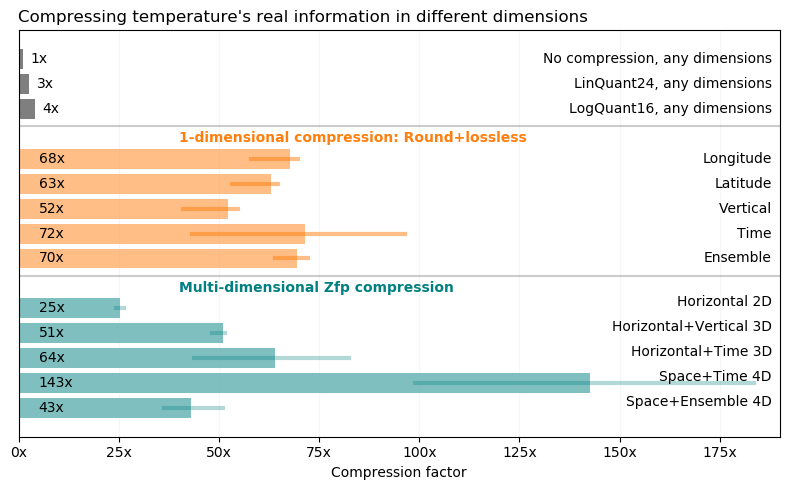

In [19]:
# PLOT
fig,ax1 = subplots(1,1,figsize=(8,5),sharex=true)

alfa = 0.5
alfa2 = 0.3
xmax = 190

i = 1
for (cf,label) in zip(cfs_basic,labels_basic)
    ax1.barh(i,cf,color="k",alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(cf+2,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"1-dimensional compression: Round+lossless",va="top",color="C1",fontweight="bold")
i += 1

for (cf,cf5,cf95,label) in zip(cfs_zstd,cfs_zstd5,cfs_zstd95,labels_zstd)
    ax1.barh(i,cf,color="C1",alpha=alfa)
    ax1.plot([cf5,cf95],[i,i],"C1",lw=3,alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(5,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"Multi-dimensional Zfp compression",va="top",color="teal",fontweight="bold")
i += 1

for (cf,cf5,cf95,label) in zip(cfs_zfp,cfs_zfp5,cfs_zfp95,labels_zfp)
    ax1.barh(i,cf,color="teal",alpha=alfa)
    ax1.plot([cf5,cf95],[i,i],color="teal",lw=3,alpha=alfa2)
    ax1.text(xmax-2,i-.25,label,ha="right",va="center")
    ax1.text(5,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%dx"))
ax1.invert_yaxis()
ax1.set_yticks([])
ax1.set_xlim(0,xmax)
ax1.set_xlabel("Compression factor")
ax1.set_title("Compressing temperature's real information in different dimensions",loc="left")
ax1.grid(alpha=0.1)
tight_layout()
savefig("../plots/cfs_dimensions2.png")